# Yet Another NY Taxi demo

In this notebook, we'll set up a connection to IRIS and walk through a few exciting query results showcasing advances in IRIS SQL throughout 2022.1 and 2022.2. First, we're using IRIS DB-API to set up a connection to IRIS.

In [1]:
import iris, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

connection = iris.connect("localhost:51789/NYTAXI", "_SYSTEM", "SYS")

The following utility paragraph just suppresses usage warnings for pandas preferring SQLAlchemy over DB-API 

In [2]:
import warnings
warnings.simplefilter("ignore")

Now we'll set up a few utility functions we'll be using throughout the demo

In [3]:
# utility vars and function to compare metrics
last_time = 0
last_grefs = 0
plans = []

def reset_compare():
    global last_time, last_grefs
    last_time = 0
    last_grefs = 0

def brag(prev, new, speed=True):
    if ((prev == 0) or (new == 0) or (prev == new)):
        return ""
    if (prev > new):
        rate = prev / new
        if (rate > 2):
            return " - {:,.2f}x {}".format(rate, "faster" if speed else "less")
        else:
            return " - {:,.0%} {}".format(rate-1, "faster" if speed else "less")
    else:
        rate = new / prev
        if (rate > 2):
            return " - {:,.2f}x {}".format(rate, "slower" if speed else "more")
        else:
            return " - {:,.0%} {}".format(rate-1, "slower" if speed else "more")

def just_sql(sql):
    c1 = connection.cursor()
    c1.execute(sql)
    result = c1.fetchall()[0][0]
    c1.close()
    return result  

def query(sql, compare = False, dtypes = None):
    global last_time, last_grefs, plans
    
    plans.append(just_sql("EXPLAIN "+sql))
    
    start_grefs = just_sql("SELECT NYTaxi.GloRefs()")
    
    start_time = time.time()
    result = pd.read_sql_query(sql, connection, dtype = dtypes)
    exec_time = time.time() - start_time
    
    exec_grefs = just_sql("SELECT NYTaxi.GloRefs()") - start_grefs - 1
    
    if compare:
        print("\nExecution time: "+str(round(exec_time,3))+"s " + brag(last_time, exec_time))
        print("Global references: "+str(exec_grefs)+" "+ brag(last_grefs, exec_grefs, False))
        last_time = exec_time
        last_grefs = exec_grefs
    else:
        print("\nExecution time: "+str(round(exec_time,3))+"s \nGlobal references: "+str(exec_grefs))
    
    return result


## A first test to validate the connection


Execution time: 1.257s 
Global references: 1248


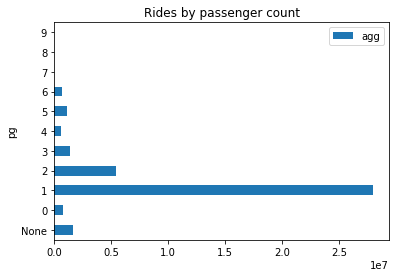

In [4]:
r = query("SELECT passenger_count AS pg, COUNT(*) AS agg "+
          "FROM NYTaxi.Rides "+
          "GROUP BY passenger_count", dtypes = { 'agg': np.int64 })

r.plot.barh(x='pg',y='agg',title="Rides by passenger count");

## Adaptive Mode in SQL

Adaptive Mode includes RunTime PlanChoice, which we can disable for the sake of the demo by using `#NORUNTIME`

In [5]:
r = query("SELECT %NORUNTIME AVG(total_amount) "+
             "FROM NYTaxi.RowRides "+
             "WHERE passenger_count > 3 "+
                   "AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2021-12-31'", True)


Execution time: 121.384s 
Global references: 83184559 


Luckily it's ON by default, so we can just leave out that hint and get great out-of-the-box performance.

In [6]:
r = query("SELECT AVG(total_amount) "+
             "FROM NYTaxi.RowRides "+
             "WHERE passenger_count > 3 "+
                   "AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2021-12-31'", True)


Execution time: 50.314s  - 2.41x faster
Global references: 2417461  - 34.41x less


The above speedup is realized by making proper use of advanced statistics collected by IRIS in 2022.1. In this particular case, we're relying on histograms that capture how our field values are distributed across rows. The chart below shows this information for the `tpep_pickup_datetime` field. 
As you'll note, almost all of the data is in our requested date range, so using the index on this supposedly selective field is not very helpful for this set of runtime parameters.


Execution time: 10.094s 
Global references: 4591


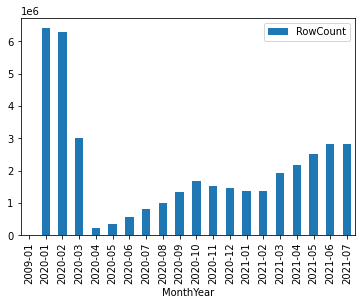

In [7]:
r = query("SELECT MonthYear, SUM(sample) As RowCount FROM (select $PIECE(CAST(CAST(tpep_pickup_datetime AS POSIXTIME) AS VARCHAR),'-',1,2) AS MonthYear, 10000 AS sample FROM %PARALLEL NYTaxi.RowRides WHERE (%ID # 10000)=0) GROUP BY MonthYear")
r.plot.bar(x='MonthYear', y='RowCount');

# Columnar Storage

Now let's run the very same query again, now targeting the columnar version of our table. 
Note the different table name in the `FROM` clause.

In [8]:
r = query("SELECT AVG(total_amount) "+
             "FROM NYTaxi.Rides "+
             "WHERE passenger_count > 2 "+
                   "AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31'")


Execution time: 2.52s 
Global references: 2015


In [9]:
print(plans[-1])

<plans>
 <plan>
 <sql>
  SELECT AVG(total_amount) FROM NYTaxi.Rides WHERE passenger_count > 2 AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31' /*#OPTIONS {"xDBCIsoLevel":"0"} */
 </sql>
 <cost value=""/>
 Call module C.
 From each parallel process:
     Accumulate the count([value]).
     Accumulate the sum([value]).
 <module name="C" top="1">
 Partition extent bitmap NYTaxi.Rides.%%DDLBEIndex, and in parallel, for each partition, looping on bitmap chunks.
 For each bitmap chunk:
     Read columnar index NYTaxi.Rides._CDM_tpeppickupdatetime, using the given chunk number.
     Apply vector and bitmap operations >=, <=, and & to produce a filter.
     Read columnar index NYTaxi.Rides._CDM_passengercount, using the given chunk number.
     Apply vector and bitmap operations >, &, defined, and & to produce a filter.
     Read columnar index NYTaxi.Rides._CDM_totalamount, using the given chunk number.
     Apply vector operations sum and count.
     Accumulate the sum([value])

That was just to show off, now let's look at some more decent examples

This query shows how far along we got in teaching the IRIS SQL engine to work with columnar storage. There's groupings, aggregates, order by and an outer JOIN!


Execution time: 29.582s 
Global references: 39649218


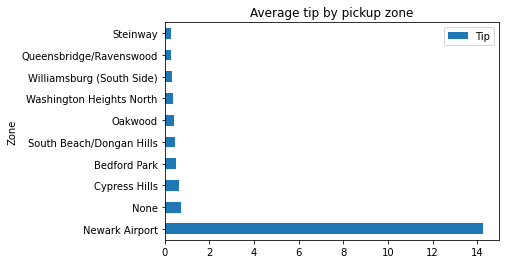

In [18]:
reset_compare()
r = query("SELECT Zone, Borough, Tip FROM ("+
              "SELECT TOP 10 PULocationID, AVG(tip_amount / fare_amount) AS Tip "+
              "FROM NYTaxi.RowRides "+
              "WHERE fare_amount > 0 "+
              "GROUP BY PULocationID "+
              "ORDER BY 2 DESC"+
          ") r LEFT JOIN NYTaxi.Zones z ON r.PULocationID = z.LocationID", 
          dtypes = { "Tip": np.double })

r.plot.barh(x="Zone", y="Tip", title="Average tip by pickup zone");


Execution time: 3.478s 
Global references: 2499


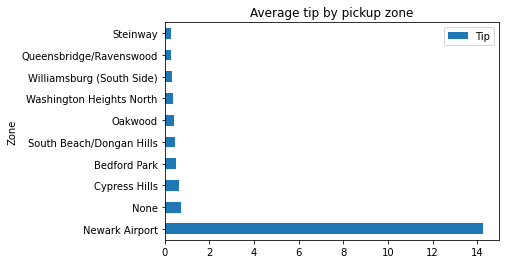

In [19]:
r = query("SELECT Zone, Borough, Tip FROM ("+
              "SELECT TOP 10 PULocationID, AVG(tip_amount / fare_amount) Tip "+
              "FROM NYTaxi.Rides "+
              "WHERE fare_amount > 0 "+
              "GROUP BY PULocationID "+
              "ORDER BY 2 DESC"+
          ") r LEFT JOIN NYTaxi.Zones z ON r.PULocationID = z.LocationID", 
          dtypes = { "Tip": np.double })

r.plot.barh(x="Zone", y="Tip", title="Average tip by pickup zone");

In [12]:
print(plans[-1])

<plans>
 <plan>
 <sql>
  SELECT Zone, Borough, Tip FROM (SELECT TOP 10 PULocationID, AVG(tip_amount / fare_amount) Tip FROM NYTaxi.Rides WHERE fare_amount > 0 GROUP BY PULocationID ORDER BY 2 DESC) r LEFT JOIN NYTaxi.Zones z ON r.PULocationID = z.LocationID /*#OPTIONS {"xDBCIsoLevel":"0"} */
 </sql>
 <cost value="22832"/>
 Call module H.
 From each parallel process:
     Check distinct values for PULocationID using temp-file A,
         subscripted by PULocationID.
     For each distinct row:
         Add a row to temp-file A, subscripted by PULocationID,
             with no node data.
     Update the accumulated count([value]) in temp-file A,
         subscripted by PULocationID
     Update the accumulated sum([value]) in temp-file A,
         subscripted by PULocationID
 <module name="H" top="1">
 Call module I.
 Read array temp-file C, looping on PULocationID.
 For each row:
     Read array temp-file D, using the given subscript values.
     Read array temp-file E, using the given 

The following query does some basic data quality style checking and would make sense to someone evaluating the data, but not at all be something your DBA would create an index for. It's an illustration of the _conversation_ you can have with big tables thanks to columnar storage.

In [13]:
reset_compare()
query("SELECT COUNT(*) AS TimeTravel "+
      "FROM NYTaxi.RowRides "+
      "WHERE tpep_pickup_datetime > tpep_dropoff_datetime")


Execution time: 29.168s 
Global references: 39649206


,TimeTravel
0,48290


In [14]:
query("SELECT COUNT(*) AS TimeTravel "+
      "FROM NYTaxi.Rides "+
      "WHERE tpep_pickup_datetime > tpep_dropoff_datetime")


Execution time: 2.571s 
Global references: 1867


,TimeTravel
0,48538


And now it's time to boast with some more spectacular differences


Execution time: 26.062s 
Global references: 39649199


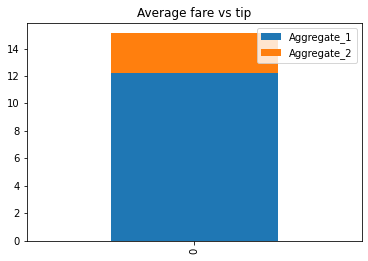

In [20]:
reset_compare()
r = query("SELECT AVG(fare_amount), AVG(tip_amount) "+
          "FROM NYTaxi.RowRides "+
          "WHERE payment_type = 1")

r.plot.bar(stacked=True, title="Average fare vs tip");


Execution time: 0.178s 
Global references: 2464


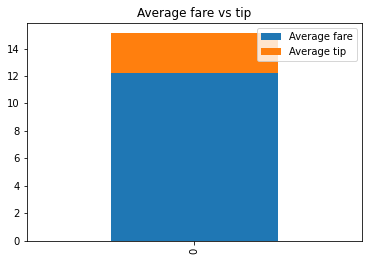

In [22]:
r = query("SELECT AVG(fare_amount) AS \"Average fare\", AVG(tip_amount) AS \"Average tip\" "+
          "FROM NYTaxi.Rides "+
          "WHERE payment_type = 1")

r.plot.bar(stacked=True, title="Average fare vs tip");